# Cut-in detection

In this notebook, the cut ins are detected. 

In [26]:
from glob import glob
import os
import matplotlib.pyplot as plt
import numpy as np
from domain_model import Activity, BSplines
from activity_detector import LateralActivityHost, LateralActivityTarget, LeadVehicle
from create_ngrams import FIELDNAMES_TARGET, FIELDNAMES_EGO, METADATA_TARGET, METADATA_EGO
from data_handler import DataHandler
from ngram import NGram
from ngram_search import find_sequence

In [2]:
# Load the data filenames
i_file = 0
datafiles = glob(os.path.join("data", "4_ngrams", '*.hdf5'))
data_handler = DataHandler(os.path.join("data", "1_hdf5", os.path.basename(datafiles[i_file])))

In [3]:
target_ngrams = NGram(FIELDNAMES_TARGET, METADATA_TARGET)
target_ngrams.from_hdf(datafiles[i_file], "targets")
ego_ngram = NGram(FIELDNAMES_EGO, METADATA_EGO)
_ = ego_ngram.from_hdf(datafiles[i_file], "ego")

In [4]:
target_tags = [dict(lateral_activity=[LateralActivityTarget.LEFT_CUT_IN.value, 
                                      LateralActivityTarget.RIGHT_CUT_IN.value],
                    lead_vehicle=[LeadVehicle.NOLEAD.value]),
               dict(lateral_activity=[LateralActivityTarget.LEFT_CUT_IN.value, 
                                      LateralActivityTarget.RIGHT_CUT_IN.value],
                    lead_vehicle=[LeadVehicle.LEAD.value])]
ego_tags = [dict(host_lateral_activity=[LateralActivityHost.LANE_FOLLOWING.value],
                 is_highway=[True]),
            dict(host_lateral_activity=[LateralActivityHost.LANE_FOLLOWING.value],
                 is_highway=[True])]

In [5]:
e = ego_ngram.ngram
cutins = []
for i, t in enumerate(target_ngrams.ngrams):
    search = find_sequence((t, e), (target_tags, ego_tags))
    while search.is_found:
        cutins.append((i, search.t_start, search.t_end))
        print(i, search)
        search = find_sequence((t, e), (target_tags, ego_tags), t_start=search.t_end+5)

3827 _StartEnd(is_found=True, t_start=1797.82, t_end=1801.15)
4099 _StartEnd(is_found=True, t_start=1956.7, t_end=1960.39)
4145 _StartEnd(is_found=True, t_start=1981.05, t_end=1983.72)
4997 _StartEnd(is_found=True, t_start=2368.42, t_end=2373.06)
5155 _StartEnd(is_found=True, t_start=2464.79, t_end=2465.22)
5607 _StartEnd(is_found=True, t_start=2558.13, t_end=2558.89)
5970 _StartEnd(is_found=True, t_start=2677.6, t_end=2677.96)


In [6]:
cutin = cutins[0]

In [7]:
target = target_ngrams.ngrams[cutin[0]]
i_first_row = target.index[target.index.get_loc(cutin[1], method="pad")]
i_last_row = target.index[target.index.get_loc(cutin[2], method="backfill")-1]
type_of_activity = "longitudinal_activity"
signal = "vx"
current_activity = target.loc[i_first_row, type_of_activity]

In [8]:
i_start = i_first_row
for i, activity in target.loc[:i_first_row, type_of_activity][::-1].iteritems():
    if not activity == current_activity:
        break
    i_start = i

In [9]:
i_end = i_start
for i, activity in target.loc[i_start:, type_of_activity].iteritems():
    i_end = i
    if not activity == current_activity:
        break

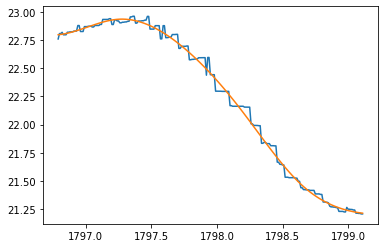

In [27]:
data = data_handler.targets[cutin[0]].loc[i_start:i_end, signal]
our_model = BSplines()
pars = our_model.fit(data.index.values, data.values)
plt.plot(data)
plt.plot(np.linspace(data.index[0], data.index[-1], 100), our_model.get_state(pars))

In [28]:
pars

{'coefficients': [0.9064033248486114,
  0.9160118870842414,
  1.0428586093081809,
  0.8861963241567581,
  0.549548544240146,
  0.08716189718522145,
  0.016624970273834656,
  0.003710443736786998],
 'scaling': [[1796.79, 1799.11], [21.20886747287335, 22.960790836400566]],
 'n_knots': 4,
 'knot_positions': []}

array([22.79681663, 22.80006342, 22.80460193, 22.810281  , 22.81694945,
       22.8244561 , 22.83264979, 22.84137934, 22.85049357, 22.85984131,
       22.86927139, 22.87863262, 22.88777384, 22.89654387, 22.90479154,
       22.91236568, 22.9191151 , 22.92488863, 22.92953511, 22.93290334,
       22.93484242, 22.93525481, 22.93416205, 22.93160185, 22.92761186,
       22.92222978, 22.91549327, 22.90744003, 22.89810773, 22.88753404,
       22.87575665, 22.86281324, 22.84874148, 22.83357905, 22.81736363,
       22.80013291, 22.78192455, 22.76277624, 22.74272566, 22.72181049,
       22.70006813, 22.67752544, 22.65419559, 22.63009081, 22.60522335,
       22.57960545, 22.55324936, 22.52616731, 22.49837156, 22.46987434,
       22.4406879 , 22.41082448, 22.38029633, 22.34911568, 22.31729478,
       22.28484588, 22.25178121, 22.21811302, 22.18385355, 22.14901505,
       22.11361324, 22.07771587, 22.04143079, 22.00486684, 21.96813287,
       21.93133776, 21.89459034, 21.85799949, 21.82167405, 21.78